# Pendientes

Nada

# Gpu

In [1]:
!nvidia-smi

Wed Oct  1 21:39:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Libraries

In [3]:
import os
import time
import warnings
from itertools import combinations
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, log_loss, r2_score, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor

warnings.filterwarnings("ignore")


In [4]:
root_data = "/content/gdrive/MyDrive/Course Folder/Forex/XAUUSD"
#/content/gdrive/MyDrive/Course Folder/Forex/XAUUSD/Data/XAUUSD_M5.csv

direction = 'Short'
direction_number = -1

symbol = 'XAUUSD'
strategy = 'Kalman'
time_frame = 'M5'

trade_evolution = 'st_Max'
result_field = 'st_PnL'



In [5]:
plt.style.use("seaborn-v0_8-darkgrid")

In [6]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


# Functions

## Strategy Functions

In [7]:
def st_pnl_close(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # 1) ensure Date is datetime & sorted
    if not np.issubdtype(df['Date'].dtype, np.datetime64):
        df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    df['st_row_PnL_close'] = np.nan

    # 3) pick only true entry‐rows: longs open_trade==1, shorts open_trade==-1
    entries = df[
        ((df['Type'] == 'Long')  & (df['Open_Trade'] == 1)) |
        ((df['Type'] == 'Short') & (df['Open_Trade'] == -1))
    ]

    for _, trade in entries.iterrows():
        entry    = trade['Entry_Date']
        exit_    = trade['st_Exit_Date'] if pd.notna(trade['st_Exit_Date']) else entry
        base     = trade['Close']
        mask     = (df['Date'] >= entry) & (df['Date'] <= exit_)

        if trade['Type'] == 'Long':
            df.loc[mask, 'st_row_PnL_close'] = (df.loc[mask, 'Close'] - base) * lot_size
        else:
            df.loc[mask, 'st_row_PnL_close'] = (base - df.loc[mask, 'Close']) * lot_size

    return df


def st_pnl_low(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if not np.issubdtype(df['Date'].dtype, np.datetime64):
        df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    df['st_row_PnL_Low'] = np.nan

    opens = df[df['Type'].notna()]
    for _, trade in opens.iterrows():
        entry = trade['Entry_Date']
        exit_ = trade['st_Exit_Date']

        # Buscar el precio de cierre en la fecha de entrada
        base_row = df[df['Date'] == entry]
        if base_row.empty:
            continue  # Saltar si no se encuentra esa fecha
        base = base_row.iloc[0]['Close']

        mask = (df['Date'] >= entry) & (df['Date'] <= exit_)

        if trade['Type'] == 'Long':
            df.loc[mask, 'st_row_PnL_low'] = (df.loc[mask, 'Low'] - base) * lot_size
        elif trade['Type'] == 'Short':
            df.loc[mask, 'st_row_PnL_low'] = (base - df.loc[mask, 'Low']) * lot_size

    return df

def st_pnl_high(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if not np.issubdtype(df['Date'].dtype, np.datetime64):
        df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    df['st_row_PnL_high'] = np.nan

    opens = df[df['Type'].notna()]
    for _, trade in opens.iterrows():
        entry = trade['Entry_Date']
        exit_ = trade['st_Exit_Date']

        # Buscar el precio de cierre en la fecha de entrada
        base_row = df[df['Date'] == entry]
        if base_row.empty:
            continue  # Saltar si no se encuentra esa fecha
        base = base_row.iloc[0]['Close']

        mask = (df['Date'] >= entry) & (df['Date'] <= exit_)

        if trade['Type'] == 'Long':
            df.loc[mask, 'st_row_PnL_high'] = (df.loc[mask, 'High'] - base) * lot_size
        elif trade['Type'] == 'Short':
            df.loc[mask, 'st_row_PnL_high'] = (base - df.loc[mask, 'High']) * lot_size

    return df

In [8]:
def st_exit_date(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['st_Exit_Date'] = pd.NaT

    long_entries = df[df['Open_Trade'] == 1]
    short_entries = df[df['Open_Trade'] == -1]
    short_signals = df['Date'][df['Open_Trade'] == -1]
    long_signals = df['Date'][df['Open_Trade'] == 1]

    for index, row in long_entries.iterrows():
        next_short_signal_date = short_signals[short_signals > row['Date']]
        if not next_short_signal_date.empty:
            exit_index = df[df['Date'] == next_short_signal_date.iloc[0]].index
            if not exit_index.empty:
                df.loc[index, 'st_Exit_Date'] = df.loc[exit_index[0], 'Date']

    for index, row in short_entries.iterrows():
        next_long_signal_date = long_signals[long_signals > row['Date']]
        if not next_long_signal_date.empty:
            exit_index = df[df['Date'] == next_long_signal_date.iloc[0]].index
            if not exit_index.empty:
                df.loc[index, 'st_Exit_Date'] = df.loc[exit_index[0], 'Date']
    return df

In [9]:
def st_duration(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['st_Duration'] = pd.NaT
    trade_rows = df[df['Type'].isin(['Long', 'Short'])]
    df.loc[trade_rows.index, 'st_Duration'] = (trade_rows['st_Exit_Date'] - trade_rows['Entry_Date']).dt.total_seconds() / 60
    return df

In [10]:
def st_max_min(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['Entry_Date'] = pd.to_datetime(df['Entry_Date'])
    df['st_Exit_Date']  = pd.to_datetime(df['st_Exit_Date'])

    df['st_Max'] = np.nan
    df['st_Min'] = np.nan

    opens = df[df['Type'].notna()]
    for idx, trade in opens.iterrows():
        entry    = trade['Entry_Date']
        exit_dt  = trade['st_Exit_Date']
        # hallar la fila de exit_dt y retroceder una
        exit_rows = df.index[df['Date'] == exit_dt]
        if not exit_rows.empty and exit_rows[0] > 0:
            prev_date = df.at[exit_rows[0] - 1, 'Date']
        else:
            continue

        mask = (df['Date'] >= entry) & (df['Date'] <= prev_date)
        # Consider max/min across the three specified columns within the mask
        subset_df = df.loc[mask, ['st_row_PnL_close', 'st_row_PnL_low', 'st_row_PnL_high']]

        if not subset_df.empty:
            # Calculate max and min across the relevant columns for the masked rows
            df.at[idx, 'st_Max'] = subset_df.values.max()
            df.at[idx, 'st_Min'] = subset_df.values.min()

    return df

In [11]:
def st_trade_type(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['trade_type'] = np.nan

    df['Date'] = pd.to_datetime(df['Date'])
    df['Entry_Date'] = pd.to_datetime(df['Entry_Date'])
    df['st_Exit_Date'] = pd.to_datetime(df['st_Exit_Date'])

    df['consecutive_trade_period'] = np.nan
    df['atr_base_change_abs'] = np.nan
    df['atr_base_change_%'] = np.nan

    trade_entries = df[df['Type'].isin(['Long', 'Short'])].copy()

    for index, trade in trade_entries.iterrows():
        entry_date = trade['Entry_Date']
        exit_date = trade['st_Exit_Date']
        trade_type = trade['Type']

        # Get the ATR value at the entry date
        base_atr_row = df[df['Date'] == entry_date]
        if base_atr_row.empty:
            continue
        base_atr = base_atr_row.iloc[0].get('ATR', np.nan)


        exit_rows = df.index[df['Date'] == exit_date]
        if not exit_rows.empty and exit_rows[0] > 0:
            prev_idx = exit_rows[0] - 1
        else:
            prev_idx = df.index[-1]

        prev_date = df.at[prev_idx, 'Date']
        mask = (df['Date'] >= entry_date) & (df['Date'] <= prev_date)
        trade_indices = df.index[mask]

        if len(trade_indices) == 0:
            continue

        if trade_type == 'Long':
            df.loc[trade_indices, 'trade type'] = 1
        elif trade_type == 'Short':
            df.loc[trade_indices, 'trade type'] = 0

        periods = np.arange(1, len(trade_indices) + 1, dtype=float)
        df.loc[trade_indices, 'consecutive_trade_period'] = periods


        if pd.notna(base_atr):
            current_atr = df.loc[trade_indices, 'ATR']
            df.loc[trade_indices, 'atr_base_change_abs'] = (current_atr - base_atr)
            if base_atr != 0:
                df.loc[trade_indices, 'atr_base_change_%'] = ((current_atr - base_atr) / base_atr) * 100
            else:
                df.loc[trade_indices, 'atr_base_change_%'] = np.nan
        else:
            df.loc[trade_indices, ['atr_base_change_abs', 'atr_base_change_%']] = np.nan

    return df

In [12]:
def st_pnl(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['st_Exit_Date'] = pd.to_datetime(df['st_Exit_Date'])
    df['st_PnL'] = np.nan

    pnl_by_date = df.set_index('Date')['st_row_PnL_close']
    entries = df[df['Type'].isin(['Long', 'Short'])]
    for idx, trade in entries.iterrows():
        exit_dt = trade['st_Exit_Date']
        exit_rows = df.index[df['Date'] == exit_dt]
        if not exit_rows.empty and exit_rows[0] > 0:
            prev_date = df.at[exit_rows[0] - 1, 'Date']
            df.at[idx, 'st_PnL'] = pnl_by_date.get(prev_date, np.nan)

    return df

In [13]:
def PnL_trade_analytics_table(df: pd.DataFrame):
    """
    Calcula métricas de rendimiento de trades con los siguientes formatos:
      • Total PnL, Avg Profit y Avg Loss → $ con separador de miles, 0 decimales
      • Win (%) y Loss (%) → 2 decimales + símbolo %
      • Profit Factor → 2 decimales
      • # Days y conteos → separador de miles
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    # ──────────────────── Cálculo numérico ────────────────────
    analytics = pd.DataFrame(index=['Strategy'])
    analytics['# Days'] = (df['Date'].max() - df['Date'].min()).days
    analytics['Total PnL']  = round(df.st_PnL.sum(), 0)
    analytics['Total Trades'] = df.st_PnL.count()
    analytics['Number of Winners'] = (df.st_PnL > 0).sum()
    analytics['Number of Losers']  = (df.st_PnL <= 0).sum()
    analytics['Win (%)']  = round(100 * analytics.at['Strategy','Number of Winners'] /
                                  analytics.at['Strategy','Total Trades'], 2)
    analytics['Loss (%)'] = round(100 * analytics.at['Strategy','Number of Losers']  /
                                  analytics.at['Strategy','Total Trades'], 2)
    analytics['Average Profit of Winning Trade'] = round(df.loc[df.st_PnL > 0, 'st_PnL'].mean(), 0)
    analytics['Average Loss of Losing Trade']    = round(abs(df.loc[df.st_PnL < 0, 'st_PnL'].mean()), 0)

    if {'Entry_Date','st_Exit_Date'}.issubset(df.columns):
        df['Entry_Date']   = pd.to_datetime(df['Entry_Date'])
        df['st_Exit_Date'] = pd.to_datetime(df['st_Exit_Date'])
        analytics['Average Holding Time'] = (df['st_Exit_Date'] - df['Entry_Date']).mean()

    tot_profit   = df.loc[df.st_PnL > 0, 'st_PnL'].sum()
    tot_loss_abs = abs(df.loc[df.st_PnL < 0, 'st_PnL'].sum())
    analytics['Profit Factor'] = round(tot_profit / tot_loss_abs, 2) if tot_loss_abs else np.nan

    # ──────────────────── Formato visual ────────────────────
    def _fmt(val, metric):
        if metric in ('Win (%)', 'Loss (%)'):
            return f'{val:,.2f}%'
        if metric in ('Total PnL',
                      'Average Profit of Winning Trade',
                      'Average Loss of Losing Trade'):
            return f'$ {val:,.0f}'
        if metric in ('# Days', 'Total Trades', 'Number of Winners', 'Number of Losers'):
            return f'{val:,.0f}'
        if metric in ('Profit Factor',):
            return f'{val:,.2f}'
        return val

    styled = analytics.T.copy()
    styled['Strategy'] = [ _fmt(v, idx) for idx, v in styled['Strategy'].items() ]

    return (styled.style
                  .set_caption('')
                  .set_table_styles([
                      {'selector':'th','props':[('font-weight','bold'), ('text-align','center')]},
                      {'selector':'td','props':[('text-align','center')]},
                      {'selector':'thead th', 'props':[('text-align','center')]}
                  ]))


In [14]:
def st_add_atr_scaled_pnls(
    df: pd.DataFrame,
    *,
    atr_col: str = "ATR",
    usd_per_point: float = 100.0,
    atr_len: int = 14
) -> pd.DataFrame:
    """
    - Elimina ÚNICAMENTE la columna 'trade_type' si existe.
    - Crea 'st_atr_PnL' y 'st_atr_max_PnL' en TODAS las filas del bloque de cada trade,
      expresando st_PnL y st_Max en múltiplos de ATR (usando el ATR de la fila de apertura).
    - Si no existe 'ATR', lo calcula (ATR(14) EWM).
    """
    df = df.copy()

    # Asegurar tipos y orden
    for c in ("Date", "Entry_Date", "st_Exit_Date"):
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    df = df.sort_values("Date").reset_index(drop=True)

    # Eliminar SOLO 'trade_type'
    if "trade_type" in df.columns:
        df.drop(columns=["trade_type"], inplace=True)

    # Asegurar ATR
    if (atr_col not in df.columns) or (df[atr_col].isna().all()):
        high = pd.to_numeric(df["High"], errors="coerce")
        low  = pd.to_numeric(df["Low"],  errors="coerce")
        close = pd.to_numeric(df["Close"], errors="coerce")
        prev_close = close.shift(1)
        tr = pd.concat([(high - low), (high - prev_close).abs(), (low - prev_close).abs()], axis=1).max(axis=1)
        df[atr_col] = tr.ewm(alpha=1.0/atr_len, adjust=False, min_periods=atr_len).mean()

    # Crear columnas destino
    df['st_atr_PnL'] = np.nan
    df['st_atr_max_PnL'] = np.nan

    # Recorrer entradas
    entries = df[df["Type"].isin(["Long", "Short"])].copy()
    if entries.empty:
        return df

    for _, trade in entries.iterrows():
        entry_dt = trade["Entry_Date"]
        exit_dt  = trade["st_Exit_Date"]

        base_row = df.loc[df["Date"] == entry_dt]
        if base_row.empty or pd.isna(base_row.iloc[0][atr_col]):
            continue
        atr_base = float(base_row.iloc[0][atr_col])
        atr_usd = atr_base * usd_per_point if np.isfinite(atr_base) else np.nan
        if not np.isfinite(atr_usd) or atr_usd == 0:
            continue

        # Barra previa al exit para delimitar bloque
        exit_rows = df.index[df["Date"] == exit_dt]
        if not exit_rows.empty and exit_rows[0] > 0:
            prev_date = df.at[exit_rows[0] - 1, "Date"]
        else:
            prev_date = df["Date"].max()

        mask = (df["Date"] >= entry_dt) & (df["Date"] <= prev_date)

        # st_atr_pnl: usar st_PnL del trade (USD) / (ATR_base * usd_per_point)
        pnl_usd = trade.get("st_PnL", np.nan)
        # reconstrucción si falta st_PnL
        if not np.isfinite(pnl_usd):
            base_close = float(base_row.iloc[0]["Close"]) if "Close" in base_row.columns else np.nan
            row_prev = df.loc[df["Date"] == prev_date]
            if row_prev.empty or not np.isfinite(base_close):
                continue
            close_prev = float(row_prev.iloc[0]["Close"])
            if trade["Type"] == "Long":
                pnl_usd = (close_prev - base_close) * usd_per_point
            else:
                pnl_usd = (base_close - close_prev) * usd_per_point
        atr_pnl = pnl_usd / atr_usd if np.isfinite(pnl_usd) else np.nan

        # st_atr_max_pnl: usar st_Max (USD) / (ATR_base * usd_per_point)
        max_usd = trade.get("st_Max", np.nan)
        if not np.isfinite(max_usd):
            cols = [c for c in ("st_row_PnL_close", "st_row_PnL_low", "st_row_PnL_high") if c in df.columns]
            if cols:
                subset = df.loc[mask, cols]
                if not subset.empty:
                    max_usd = np.nanmax(subset.values)
        atr_max_pnl = (max_usd / atr_usd) if np.isfinite(max_usd) else np.nan

        # Rellenar en todas las filas del bloque
        df.loc[mask, 'st_atr_PnL'] = atr_pnl
        df.loc[mask, 'st_atr_max_PnL'] = atr_max_pnl

    return df

In [15]:
def st_add_atr_multipliers_from_prices(
    df: pd.DataFrame,
    *,
    atr_col: str = "ATR",
    atr_len: int = 14
) -> pd.DataFrame:
    """
    Compute ATR-multiplier columns based on PRICES (not USD PnL), per your formulas:

      LONG:
        price_max_profit  = entry_close + (ATR_entry * atr_multiplier_max)
        price_close_trade = entry_close + (ATR_entry * atr_multiplier_close)

      SHORT:
        price_max_profit  = entry_close - (ATR_entry * atr_multiplier_max)
        price_close_trade = entry_close - (ATR_entry * atr_multiplier_close)

    Definitions used:
      • entry_close  := Close at Entry_Date
      • ATR_entry    := ATR value at Entry_Date
      • price_close_trade := Close at the bar immediately BEFORE st_Exit_Date
      • price_max_profit  := For Long → max High within [Entry_Date, bar_before_exit]
                             For Short → min Low  within [Entry_Date, bar_before_exit]

    The resulting multipliers are written across every row of each trade block:
      • st_atr_PnL      → multiplier to reach the close-trade price
      • st_atr_max_PnL  → multiplier to reach the max-profit price

    If ATR is missing, it is computed as an EWM (Wilder-style) of True Range.
    """

    out = df.copy()

    # Ensure types and order
    for c in ("Date", "Entry_Date", "st_Exit_Date"):
        if c in out.columns:
            out[c] = pd.to_datetime(out[c], errors="coerce")
    out = out.sort_values("Date").reset_index(drop=True)

    # Ensure numeric price columns
    for c in ("Close", "High", "Low"):
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")

    # Ensure ATR exists (EWM of True Range if missing or all-NaN)
    if (atr_col not in out.columns) or (out[atr_col].isna().all()):
        high = out["High"]
        low  = out["Low"]
        close = out["Close"]
        prev_close = close.shift(1)
        tr = pd.concat([(high - low),
                        (high - prev_close).abs(),
                        (low  - prev_close).abs()], axis=1).max(axis=1)
        out[atr_col] = tr.ewm(alpha=1.0/atr_len, adjust=False, min_periods=atr_len).mean()

    # Prepare destination columns
    out["st_atr_PnL"] = np.nan
    out["st_atr_max_PnL"] = np.nan

    # Iterate over trades (rows where Type is 'Long' or 'Short')
    if "Type" not in out.columns:
        return out

    trades = out[out["Type"].isin(["Long", "Short"])].copy()
    for _, tr in trades.iterrows():
        entry_dt = tr.get("Entry_Date", pd.NaT)
        exit_dt  = tr.get("st_Exit_Date", pd.NaT)
        side     = tr.get("Type", None)

        if pd.isna(entry_dt) or side not in ("Long", "Short"):
            continue

        # Base row at entry
        base_row = out.loc[out["Date"] == entry_dt]
        if base_row.empty:
            continue

        entry_close = float(base_row.iloc[0]["Close"])
        atr_entry   = float(base_row.iloc[0][atr_col]) if atr_col in base_row.columns else np.nan
        if not np.isfinite(entry_close) or not np.isfinite(atr_entry) or atr_entry <= 0:
            continue

        # Determine bar_before_exit to delimit the trade block
        if pd.notna(exit_dt):
            exit_idx = out.index[out["Date"] == exit_dt]
            if len(exit_idx) > 0 and exit_idx[0] > 0:
                bar_before_exit_date = out.at[exit_idx[0] - 1, "Date"]
            else:
                # If exit is the first row or not found, consider up to the last available row
                bar_before_exit_date = out["Date"].max()
        else:
            # If no exit, consider up to the last available row
            bar_before_exit_date = out["Date"].max()

        # Mask for the trade block [Entry_Date, bar_before_exit]
        mask = (out["Date"] >= entry_dt) & (out["Date"] <= bar_before_exit_date)
        block = out.loc[mask, ["High", "Low", "Close"]].dropna()
        if block.empty:
            continue

        # Prices of interest
        price_close_trade = float(out.loc[out["Date"] == bar_before_exit_date, "Close"].iloc[0])

        if side == "Long":
            # Max favorable price in block is the highest High
            price_max_profit = float(block["High"].max())
            atr_mult_close = (price_close_trade - entry_close) / atr_entry
            atr_mult_max   = (price_max_profit  - entry_close) / atr_entry
        else:  # Short
            # Max favorable price for Short is the lowest Low
            price_max_profit = float(block["Low"].min())
            atr_mult_close = (entry_close - price_close_trade) / atr_entry
            atr_mult_max   = (entry_close - price_max_profit ) / atr_entry

        # Write the same multiplier across the trade block
        out.loc[mask, "st_atr_PnL"] = atr_mult_close
        out.loc[mask, "st_atr_max_PnL"] = atr_mult_max

    return out

## Features

In [16]:
def kalman_line(source, kalman_length: int, smooth: int):
    """
    Pine -> Python (solo 'kalman_line'), replicando la EMA de TradingView con
    *semilla SMA* (como ta.ema) sobre el núcleo Kalman kf_c.

    Parámetros
    ----------
    source : pd.Series o array-like de floats (precio crudo, sin diff/returns)
    kalman_length : int   (equivale a length_kal en Pine)
    smooth : int          (equivale a smooth_kal en Pine -> ta.ema(kf_c, smooth))

    Retorna
    -------
    Mismo tipo que `source`: pd.Series o np.ndarray con la línea Kalman suavizada.
    """
    import numpy as np
    import pandas as pd

    # normalizamos tipos
    is_series = hasattr(source, "index")
    idx = source.index if is_series else None
    x = np.asarray(source, dtype=np.float64)
    n = x.shape[0]
    if n == 0:
        return source

    # ---------- núcleo Kalman idéntico al Pine ----------
    sqrt_term   = np.sqrt((kalman_length / 10000.0) * 2.0)
    length_term = kalman_length / 10000.0

    kf_c   = np.empty(n, dtype=np.float64)
    velo_c = np.empty(n, dtype=np.float64)

    # bar 0 (nz(kf_c[1], source) y nz(velo_c[1], 0))
    kf_c[0] = x[0]
    velo_c[0] = 0.0

    for i in range(1, n):
        prev_kf = kf_c[i - 1]
        dk_c = x[i] - prev_kf
        smooth_c = prev_kf + dk_c * sqrt_term
        velo_c[i] = velo_c[i - 1] + length_term * dk_c
        kf_c[i] = smooth_c + velo_c[i]

    # ---------- EMA con semilla SMA (comportamiento ta.ema de TV) ----------
    L = int(max(1, smooth))
    alpha = 2.0 / (L + 1.0)
    ema = np.full(n, np.nan, dtype=np.float64)

    if n < L:
        # con pocas barras, igualamos al promedio simple disponible
        ema[-1] = np.nanmean(kf_c)
    else:
        # seed = SMA de las primeras L barras
        seed = np.mean(kf_c[:L])
        ema[L - 1] = seed
        for i in range(L, n):
            ema[i] = alpha * kf_c[i] + (1.0 - alpha) * ema[i - 1]

    return (pd.Series(ema, index=idx) if is_series else ema)


In [17]:
def create_features(
    stock_data: pd.DataFrame,
    return_components: bool = False
) -> Union[pd.DataFrame, Tuple[pd.DataFrame, Dict[str, pd.DataFrame]]]:

    kalman_periods = [300, 600, 900]
    kalman_smooth_kal = 3

    component_frames: Dict[str, pd.DataFrame] = {}

    def _unique_pairwise(columns: List[str]) -> List[Tuple[str, str]]:
        """Return ordered unique column pairs without self-pairings."""
        unique_columns = list(dict.fromkeys(columns))
        return list(combinations(unique_columns, 2))

    # ───────────────────────── Kalman y derivados ───────────────────────
    t0 = time.time()
    kal_cols = []
    kalman_features = pd.DataFrame(index=stock_data.index)
    kalman_900_series: Optional[pd.Series] = None
    for period in tqdm(kalman_periods, desc="Kalman & Derivatives"):
        kal = pd.Series(
            kalman_line(stock_data['Close'], kalman_length=period, smooth=kalman_smooth_kal),
            index=stock_data.index
        )

        if kal.isna().any():
            kal = kal.ffill()
            if kal.isna().any():
                kal = kal.bfill()
        kname = f'Kal_{period}'
        kal_cols.append(kname)

        kalman_features[kname] = kal
        if period == 900:
            kalman_900_series = kal

    tqdm.write(f"[Timing] Kalman block: {time.time()-t0:.2f}s")
    component_frames['Kalman'] = kalman_features.copy()
    features = kalman_features.copy()

    if return_components:
        component_frames['Create_Features'] = features.copy()
        return features, component_frames

    return features

In [18]:
def scale_minmax(features: pd.DataFrame, window: int) -> pd.DataFrame:
    """Apply Min-Max scaling using a rolling window.

    Parameters
    ----------
    features : pd.DataFrame
        Feature block to scale.
    window : int
        Rolling window size.

    Returns
    -------
    pd.DataFrame
        Min-Max scaled feature block preserving the original index.
    """
    if features.empty:
        return pd.DataFrame(index=features.index)

    numeric_cols = features.select_dtypes(include=np.number).columns
    if numeric_cols.empty:
        return pd.DataFrame(index=features.index)

    scaled_features = pd.DataFrame(index=features.index)
    for col in numeric_cols:
        rolling = features[col].rolling(window=window, min_periods=window)
        rolling_min = rolling.min()
        rolling_max = rolling.max()

        range_ = (rolling_max - rolling_min).replace(0, np.nan)
        scaled_features[col] = (features[col] - rolling_min) / range_

    return scaled_features

def apply_minmax_scaling(
    features: pd.DataFrame,
    windows: Tuple[int, ...] = (3,),
    prefix: str = "a_minimal_"
) -> pd.DataFrame:
    """Apply Min-Max scaling using multiple rolling window lengths.

    Parameters
    ----------
    features : pd.DataFrame
        Feature block to scale.
    windows : Tuple[int, ...], optional
        Collection of rolling window sizes to apply, by default (3).
    prefix : str, optional
        Prefix to add to each generated Min-Max column, by default "a_minimal_".

    Returns
    -------
    pd.DataFrame
        DataFrame with Min-Max scaled features for the requested windows.
    """
    if features.empty:
        return pd.DataFrame(index=features.index)

    scaled_blocks = []
    for window in windows:
        if window <= 1:
            continue
        window_scaled = scale_minmax(features, window=window)
        if window_scaled.empty:
            continue
        rename_map = {col: f"{prefix}{col}_minmax_{window}" for col in window_scaled.columns}
        scaled_blocks.append(window_scaled.rename(columns=rename_map))

    if not scaled_blocks:
        return pd.DataFrame(index=features.index)

    return pd.concat(scaled_blocks, axis=1)


In [19]:
def scale_feature_block(features: pd.DataFrame, window: int = 200) -> pd.DataFrame:
    """Scale features using a rolling window standardization.

    Parameters
    ----------
    features : pd.DataFrame
        Feature block to scale.
    window : int, optional
        Rolling window size, by default 200.

    Returns
    -------
    pd.DataFrame
        Scaled feature block preserving the original index.
    """
    if features.empty:
        return features.copy()

    numeric_cols = features.select_dtypes(include=np.number).columns
    scaled_features = features.copy()

    if not numeric_cols.empty:
        rolling = features[numeric_cols].rolling(window=window, min_periods=window)
        mean = rolling.mean()
        std = rolling.std()

        std = std.replace(0, np.nan)

        scaled_features[numeric_cols] = (features[numeric_cols] - mean) / std

    return scaled_features


# 5_min

In [41]:
# Read the CSV file
df_5min = pd.read_csv(root_data+'/Data/'+symbol+'_M5.csv')
df_5min = df_5min.iloc[-50000:,]

print('Min_Date : ', df_5min['Date'].min())
print('Min_Date : ', df_5min['Date'].max())
print('Number_Rows = ',len(df_5min))
print('\n')

df_5min.tail()

Min_Date :  2024-11-08 21:20:00
Min_Date :  2025-07-25 23:55:00
Number_Rows =  50000




,Date,Open,High,Low,Close,Volume,Spread
465713,2025-07-25 23:35:00,3338.59,3339.14,3338.04,3338.81,197,5
465714,2025-07-25 23:40:00,3338.81,3338.92,3337.56,3338.69,194,5
465715,2025-07-25 23:45:00,3338.69,3338.69,3336.64,3336.73,195,40
465716,2025-07-25 23:50:00,3336.73,3336.86,3336.12,3336.52,192,40
465717,2025-07-25 23:55:00,3336.52,3336.88,3336.44,3336.80,82,40


## Strategy

In [42]:

length_1 = 300
length_2 = 520
length_3 = 710
length_4 = 1130

smooth_1 = 3
smooth_2 = 3
smooth_3 = 3
smooth_4 = 7

df_5min['kal_1'] = kalman_line(df_5min['Close'],length_1, smooth_1)
df_5min['kal_2'] = kalman_line(df_5min['Close'],length_2, smooth_2)
df_5min['kal_3'] = kalman_line(df_5min['Close'],length_3, smooth_3)
df_5min['kal_4'] = kalman_line(df_5min['Close'],length_4, smooth_4)

In [43]:
bullish_condition = (df_5min['kal_1'] > df_5min['kal_1'].shift()) & \
                    (df_5min['kal_2'] > df_5min['kal_2'].shift()) & \
                    (df_5min['kal_3'] > df_5min['kal_3'].shift())

bearish_condition = (df_5min['kal_1'] < df_5min['kal_1'].shift()) & \
                    (df_5min['kal_2'] < df_5min['kal_2'].shift()) & \
                    (df_5min['kal_3'] < df_5min['kal_3'].shift())


df_5min['Open_Trade_1'] = np.where(bullish_condition, 1, np.where(bearish_condition, -1, np.nan))
df_5min['Open_Trade'] = np.where(df_5min['Open_Trade_1'] == df_5min['Open_Trade_1'].shift(1), np.nan, df_5min['Open_Trade_1'])

close_bearish_condition = df_5min['Open_Trade'] == 1
close_bullish_condition = df_5min['Open_Trade'] == -1

df_5min['Close_Trade_1'] = np.where(df_5min['kal_4'] < df_5min['kal_4'].shift(), -1, np.where(df_5min['kal_4'] > df_5min['kal_4'].shift(), 1, np.nan))
df_5min['Close_Trade'] = np.where(df_5min['Close_Trade_1'] == df_5min['Close_Trade_1'].shift(1), np.nan, df_5min['Close_Trade_1'])

df_5min = df_5min.drop(columns=['Open_Trade_1', 'Close_Trade_1'])
#df_5min

In [44]:
df_5min['Entry_Date'] = pd.NaT
df_5min.loc[df_5min['Open_Trade'] ==  1, 'Entry_Date'] = df_5min['Date'][df_5min['Open_Trade'] == 1]
df_5min.loc[df_5min['Open_Trade'] == -1, 'Entry_Date'] = df_5min['Date'][df_5min['Open_Trade'] == -1]

df_5min['Type'] = np.nan
df_5min.loc[df_5min['Open_Trade'] ==  1, 'Type'] = 'Long'
df_5min.loc[df_5min['Open_Trade'] == -1, 'Type'] = 'Short'
#df_5min.loc[df_5min['Open_Trade'] == -1, 'Type'] = 'Short'
#df_5min['Type'] = df_5min['Type'].ffill()

df_5min['Trade_Number'] = np.nan
start_mask = df_5min["Entry_Date"].notna() & df_5min["Type"].notna()

df_5min["Trade_Number"] = start_mask.cumsum()
first_trade = df_5min["Trade_Number"].ne(0).idxmax()
df_5min.loc[: first_trade - 1, "Trade_Number"] = np.nan
df_5min.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Spread', 'kal_1',
       'kal_2', 'kal_3', 'kal_4', 'Open_Trade', 'Close_Trade', 'Entry_Date',
       'Type', 'Trade_Number'],
      dtype='object')

In [45]:
columns_to_see = ['Date', 'Close','Open_Trade', 'Type', 'Entry_Date','st_Exit_Date','Trade_Number']

#df_5min.loc[df_5min['Open_Trade'].notna(), :].head(10)
#df_5min.loc[((df_5min['Open_Trade'].notna()) & (df_5min['Type']=='Short')), :].head(10)

In [46]:
lot_size = 100

df_5min = st_exit_date(df_5min)
print(df_5min.shape)
df_5min = st_trade_type(df_5min)
print(df_5min.shape)
df_5min = st_duration(df_5min)
print(df_5min.shape)
df_5min = st_pnl_close(df_5min)
print(df_5min.shape)
df_5min = st_pnl_high(df_5min)
print(df_5min.shape)
df_5min = st_pnl_low(df_5min)
print(df_5min.shape)
df_5min = st_max_min(df_5min)
print(df_5min.shape)
df_5min = st_pnl(df_5min)
print(df_5min.shape)
df_5min = st_add_atr_scaled_pnls(df_5min, atr_col="ATR", usd_per_point=100.0, atr_len=14)
print(df_5min.columns)
df_5min = st_add_atr_multipliers_from_prices(df_5min)
print(df_5min.columns)

(50000, 17)
(50000, 22)
(50000, 23)
(50000, 24)
(50000, 25)
(50000, 27)
(50000, 29)
(50000, 30)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Spread', 'kal_1',
       'kal_2', 'kal_3', 'kal_4', 'Open_Trade', 'Close_Trade', 'Entry_Date',
       'Type', 'Trade_Number', 'st_Exit_Date', 'consecutive_trade_period',
       'atr_base_change_abs', 'atr_base_change_%', 'trade type', 'st_Duration',
       'st_row_PnL_close', 'st_row_PnL_high', 'st_row_PnL_Low',
       'st_row_PnL_low', 'st_Max', 'st_Min', 'st_PnL', 'ATR', 'st_atr_PnL',
       'st_atr_max_PnL'],
      dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Spread', 'kal_1',
       'kal_2', 'kal_3', 'kal_4', 'Open_Trade', 'Close_Trade', 'Entry_Date',
       'Type', 'Trade_Number', 'st_Exit_Date', 'consecutive_trade_period',
       'atr_base_change_abs', 'atr_base_change_%', 'trade type', 'st_Duration',
       'st_row_PnL_close', 'st_row_PnL_high', 'st_row_PnL_Low',
       'st_row_PnL_low', 'st_Max', '

In [47]:
columns_to_see = ['Date', 'Close','ATR','trade type', 'Open_Trade',
                  'st_Max', 'st_Min', 'st_PnL', 'Trade_Number', 'consecutive_trade_period', 'atr_base_change_abs', 'atr_base_change_%']

#df_5min.loc[df_5min['Trade_Number']==5, columns_to_see]

In [48]:
df_5min.to_csv(root_data+'/Results/'+symbol+'_'+strategy+'_'+time_frame+'_DRL_TradeResults.csv', index=False)

In [49]:
df_5min_st_pnl = df_5min.copy()
df_5min_st_pnl = df_5min_st_pnl[df_5min_st_pnl['Entry_Date'].notna()]
#df_5min_sl_pnl.head(5)

In [50]:
trade_analysis = PnL_trade_analytics_table(df_5min_st_pnl)
trade_analysis

,Strategy
# Days,259
Total PnL,"$ 730,664"
Total Trades,"7,124"
Number of Winners,"2,996"
Number of Losers,"4,128"
Win (%),42.06%
Loss (%),57.94%
Average Profit of Winning Trade,$ 384
Average Loss of Losing Trade,$ 127
Average Holding Time,0 days 01:05:08.085345311


In [51]:
print(df_5min_st_pnl['st_PnL'].sum())

730664.0000000028


## ML_Features

In [52]:
start_time = time.time()

# --- Inline feature creation logic from create_features function ---
kalman_periods = [300, 600, 900]
kalman_smooth_kal = 3

# Kalman and Derivatives
t0 = time.time()
kal_cols = []
for period in tqdm(kalman_periods, desc="Kalman & Derivatives"):
    kal = pd.Series(
        kalman_line(df_5min['Close'], kalman_length=period, smooth=kalman_smooth_kal),
        index=df_5min.index
    )

    if kal.isna().any():
        kal = kal.ffill()
        if kal.isna().any():
            kal = kal.bfill()
    kname = f'Kal_{period}'
    kal_cols.append(kname)
    df_5min[kname] = kal

tqdm.write(f"[Timing] Kalman block: {time.time()-t0:.2f}s")

# --- End of inlined feature creation logic ---

# Apply specific scaling and min-max scaling to Kalman features within df_5min
kalman_features_to_scale = df_5min[['Kal_300', 'Kal_600', 'Kal_900']].copy()
scaled_kalman = scale_feature_block(kalman_features_to_scale, window=900)
minmax_kalman = apply_minmax_scaling(kalman_features_to_scale, windows=(3,), prefix="minmax_")

# Rename columns with specified prefixes and merge into df_5min
scaled_kalman = scaled_kalman.rename(columns={col: f"scale_{col}" for col in scaled_kalman.columns})
minmax_kalman = minmax_kalman.rename(columns={col: f"{col}" for col in minmax_kalman.columns})

# Calculate and add the difference for scale_Kal_300
if 'scale_Kal_300' in scaled_kalman.columns:
    scale_kal_300 = scaled_kalman['scale_Kal_300'].copy()
    scale_kal_300 = scale_kal_300.ffill().bfill()
    scale_kal_300_diff = scale_kal_300.diff().fillna(0)
    scaled_kalman['scale_Kal_300_diff'] = scale_kal_300_diff

    kalman_input = scale_kal_300_diff.ffill().bfill()
    scaled_kalman['kalman_scale_Kal_300_diff'] = pd.Series(
        kalman_line(kalman_input.values, kalman_length=300, smooth=3),
        index=scaled_kalman.index
    )
    scaled_kalman['kalman_scale_Kal_300_diff'] = scaled_kalman['kalman_scale_Kal_300_diff'].ffill().bfill()

# Merge the scaled and minmax features into df_5min
df_5min = df_5min.merge(scaled_kalman, left_index=True, right_index=True, how='left')
df_5min = df_5min.merge(minmax_kalman, left_index=True, right_index=True, how='left')


execution_time = time.time() - start_time

print(f"Number of features are: {len(df_5min.columns)}")
print(df_5min.shape)
print(f"Execution time: {execution_time:.2f} seconds")
# Remove saving to separate files
# print(f"Saved {len(m5_raw_blocks) * 2} DataFrames for the M5 timeframe.")
df_5min.tail(5)

Kalman & Derivatives:   0%|          | 0/3 [00:00<?, ?it/s]

[Timing] Kalman block: 0.22s
Number of features are: 43
(50000, 43)
Execution time: 0.34 seconds


,Date,Open,High,Low,Close,Volume,Spread,kal_1,kal_2,kal_3,...,Kal_600,Kal_900,scale_Kal_300,scale_Kal_600,scale_Kal_900,scale_Kal_300_diff,kalman_scale_Kal_300_diff,minmax_Kal_300_minmax_3,minmax_Kal_600_minmax_3,minmax_Kal_900_minmax_3
49995,2025-07-25 23:35:00,3338.59,3339.14,3338.04,3338.81,197,5,3337.487742,3337.474453,3337.594954,...,3337.520497,3337.729799,-1.477017,-1.476956,-1.470946,0.008125,-0.004964,1.000000,1.000000,1.000000
49996,2025-07-25 23:40:00,3338.81,3338.92,3337.56,3338.69,194,5,3337.666494,3337.788028,3337.971092,...,3337.864862,3338.139540,-1.467886,-1.462681,-1.454682,0.009131,-0.002064,1.000000,1.000000,1.000000
49997,2025-07-25 23:45:00,3338.69,3338.69,3336.64,3336.73,195,40,3337.579710,3337.701767,3337.841840,...,3337.763807,3337.947434,-1.467100,-1.462393,-1.457295,0.000786,-0.000407,0.514502,0.706546,0.531152
49998,2025-07-25 23:50:00,3336.73,3336.86,3336.12,3336.52,192,40,3337.362996,3337.431623,3337.497565,...,3337.464038,3337.522690,-1.470401,-1.468341,-1.467189,-0.003301,0.000010,0.000000,0.000000,0.000000
49999,2025-07-25 23:55:00,3336.52,3336.88,3336.44,3336.80,82,40,3337.152870,3337.178498,3337.191373,...,3337.188822,3337.167067,-1.473516,-1.473531,-1.474909,-0.003116,-0.000123,0.000000,0.000000,0.000000


In [62]:
print("NaN counts per column (scaled, sorted):")
print(df_5min.isnull().sum().sort_values(ascending=False), '')

NaN counts per column (scaled, sorted):
st_row_PnL_Low               50000
atr_base_change_%            50000
atr_base_change_abs          50000
Close_Trade                  43076
st_Exit_Date                 42876
st_Max                       42876
st_Duration                  42876
st_Min                       42876
st_PnL                       42876
Type                         42875
Entry_Date                   42875
Open_Trade                   42875
scale_Kal_300                  899
scale_Kal_900                  899
scale_Kal_600                  899
st_atr_max_PnL                  17
st_atr_PnL                      17
ATR                             13
kal_4                            6
st_row_PnL_low                   5
st_row_PnL_high                  5
st_row_PnL_close                 5
minmax_Kal_600_minmax_3          3
minmax_Kal_900_minmax_3          3
trade type                       3
Trade_Number                     3
consecutive_trade_period         3
minmax_Kal_300_

In [59]:
print(df_5min.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Spread', 'kal_1',
       'kal_2', 'kal_3', 'kal_4', 'Open_Trade', 'Close_Trade', 'Entry_Date',
       'Type', 'Trade_Number', 'st_Exit_Date', 'consecutive_trade_period',
       'atr_base_change_abs', 'atr_base_change_%', 'trade type', 'st_Duration',
       'st_row_PnL_close', 'st_row_PnL_high', 'st_row_PnL_Low',
       'st_row_PnL_low', 'st_Max', 'st_Min', 'st_PnL', 'ATR', 'st_atr_PnL',
       'st_atr_max_PnL', 'Kal_300', 'Kal_600', 'Kal_900', 'scale_Kal_300',
       'scale_Kal_600', 'scale_Kal_900', 'scale_Kal_300_diff',
       'kalman_scale_Kal_300_diff', 'minmax_Kal_300_minmax_3',
       'minmax_Kal_600_minmax_3', 'minmax_Kal_900_minmax_3'],
      dtype='object')


## Plots

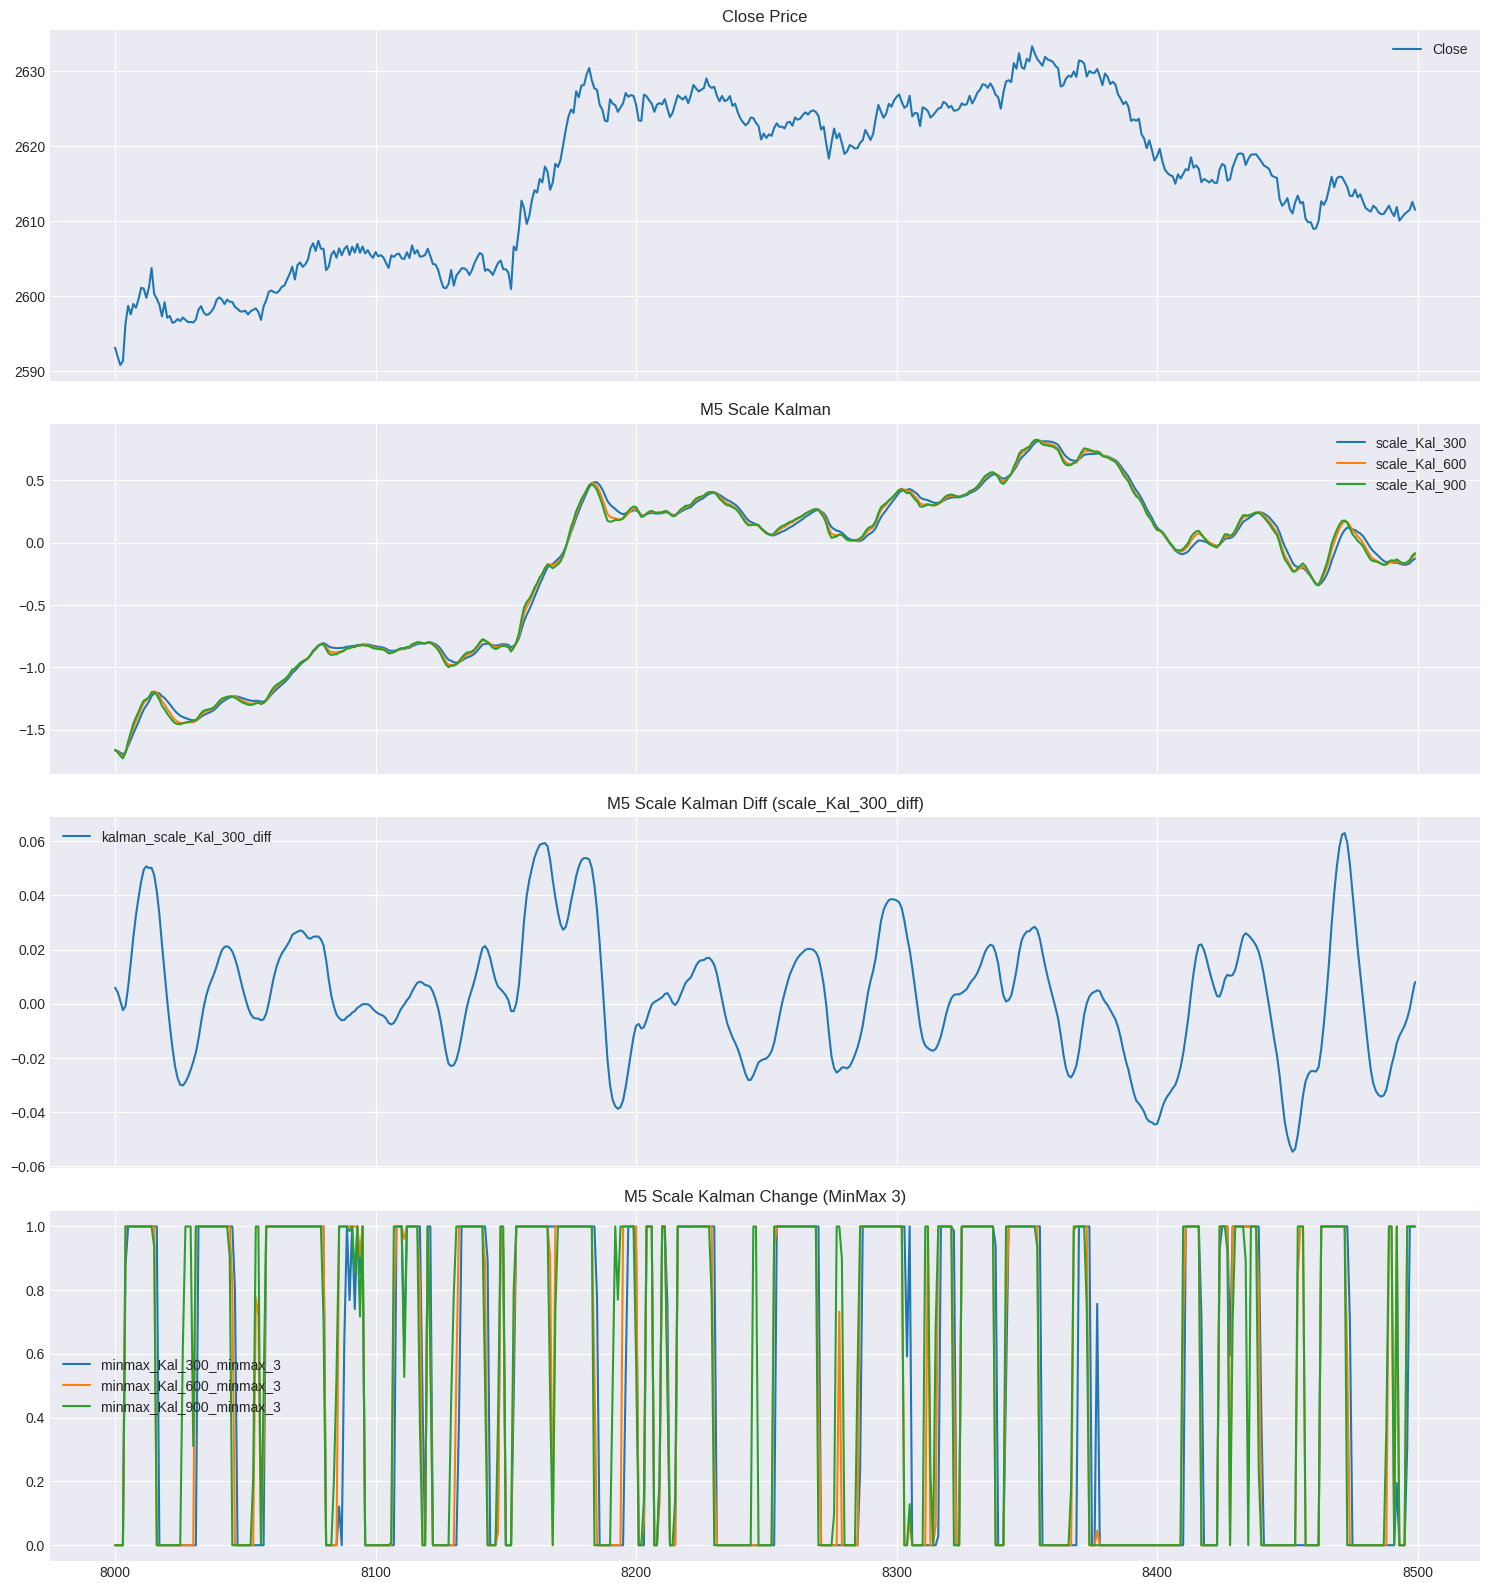

In [64]:

# Define the row range for plotting
start_row = 8000
end_row = 8500

# Select the data for the specified row range from the scaled features
plot_df = df_5min.iloc[start_row:end_row].copy()
plot_df['Date'] = plot_df.index # Add Date column from index for plotting

# Define the columns to plot in each chart
chart1_cols = ['Close']
chart2_cols = ['scale_Kal_300', 'scale_Kal_600', 'scale_Kal_900']
chart3_cols = ['minmax_Kal_300_minmax_3', 'minmax_Kal_600_minmax_3', 'minmax_Kal_900_minmax_3']
chart4_cols = ['kalman_scale_Kal_300_diff']


# Determine the number of subplots (only include charts with available columns in plot_df)
num_plots = 0
if any(col in plot_df.columns for col in chart1_cols): num_plots += 1
if any(col in plot_df.columns for col in chart2_cols): num_plots += 1
if any(col in plot_df.columns for col in chart3_cols): num_plots += 1
if any(col in plot_df.columns for col in chart4_cols): num_plots += 1


# Create the subplots
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(15, 4 * num_plots), sharex=True)

# Ensure axes is an array even if only one plot
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

current_plot_index = 0

# Plot Chart 1: Close Price
if any(col in plot_df.columns for col in chart1_cols):
    axes[current_plot_index].plot(plot_df['Date'], plot_df[chart1_cols])
    axes[current_plot_index].set_title('Close Price')
    axes[current_plot_index].grid(True)
    axes[current_plot_index].legend(chart1_cols)
    current_plot_index += 1


# Plot Chart 2: M5 Scale Kalman indicators
if any(col in plot_df.columns for col in chart2_cols):
    axes[current_plot_index].plot(plot_df['Date'], plot_df[chart2_cols])
    axes[current_plot_index].set_title('M5 Scale Kalman')
    axes[current_plot_index].grid(True)
    axes[current_plot_index].legend(chart2_cols)
    current_plot_index += 1

# Plot Chart 4: M5 Scale Kalman Diff indicator
if any(col in plot_df.columns for col in chart4_cols):
    axes[current_plot_index].plot(plot_df['Date'], plot_df[chart4_cols])
    axes[current_plot_index].set_title('M5 Scale Kalman Diff (scale_Kal_300_diff)')
    axes[current_plot_index].grid(True)
    axes[current_plot_index].legend(chart4_cols)
    current_plot_index += 1


# Plot Chart 3: M5 Scale Kalman Change indicators
if any(col in plot_df.columns for col in chart3_cols):
    axes[current_plot_index].plot(plot_df['Date'], plot_df[chart3_cols])
    axes[current_plot_index].set_title('M5 Scale Kalman Change (MinMax 3)')
    axes[current_plot_index].grid(True)
    axes[current_plot_index].legend(chart3_cols)
    current_plot_index += 1

plt.tight_layout()
plt.show()


# Feature Importance

## Labels

In [ ]:
df_5min['Date'] = pd.to_datetime(df_5min['Date'])
df_5min = df_5min.set_index('Date')

In [ ]:
#df_5min.loc[:,['Close','Open_Trade', 'Close_Trade', 'Entry_Date', 'Type', 'Trade_Number', 'st_Exit_Date']]

In [ ]:
# --- Parámetros / campos
result_field = 'st_atr_max_PnL'

#valid = (
#    (df_5min['Type'] == direction) &
#    (df_5min['Open_Trade'].isin([1, -1])) &
#    (df_5min[result_field].notna()))

valid = (
    (df_5min['Open_Trade'].isin([1, -1])) &
    (df_5min[result_field].notna()))


# --- Etiquetado en la columna "df_5minel" con valores 4/5/6
df_5min['label'] = np.nan
df_5min.loc[valid & (df_5min[result_field] <= 1), 'label'] = 0
df_5min.loc[valid & (df_5min[result_field] >= 1), 'label'] = 1


# --- Mantener solo filas válidas y con label
df_5min = df_5min.loc[valid & df_5min['label'].notna()].copy()
df_5min['label'] = df_5min['label'].astype('int8')

# --- Ver distribución de labels 4/5/6
print('\nValue counts de label 4/5/6:')
print(df_5min['label'].value_counts(dropna=False).sort_index())



Value counts de label 4/5/6:
label
0    3391
1    3733
Name: count, dtype: int64


## Features

In [ ]:
# Use the in-memory raw feature block instead of reading from disk
if 'raw_feat_5min' not in globals():
    raise RuntimeError('raw_feat_5min is not available. Run the feature generation cell first.')

raw_feat_5min = raw_feat_5min.copy()
raw_feat_5min['Date'] = pd.to_datetime(raw_feat_5min['Date'], errors='coerce')
print(raw_feat_5min.shape)
list(raw_feat_5min.columns)
#raw_feat_5min.head(5)


(50000, 4)


['Unnamed: 0', 'Kal_300', 'Kal_600', 'Kal_900']

In [ ]:
# Use the in-memory scaled feature block instead of reading from disk
if 'scale_feat_5min' not in globals():
    raise RuntimeError('scale_feat_5min is not available. Run the feature generation cell first.')

scale_feat_5min = scale_feat_5min.copy()
scale_feat_5min['Date'] = pd.to_datetime(scale_feat_5min['Date'], errors='coerce')
print(scale_feat_5min.shape)
list(scale_feat_5min.columns)
#scale_feat_5min.head(5)


KeyError: 'Date'

## Merge

In [ ]:
# Initialize feature_df with the first dataframe to merge
df_base = df_5min.reset_index()
df = df_base[['Date', 'label', 'Open_Trade', 'kal_1', 'kal_2', 'kal_3', 'kal_4', 'Close']].copy()

df = df.merge(raw_feat_5min, on='Date', how='left')
print('Merged raw_feat_5min.')

df = df.merge(scale_feat_5min, on='Date', how='left')
print('Merged scale_feat_5min.')

df = df.sort_values('Date').set_index('Date').ffill().reset_index()
cols = df.columns.tolist()

combined_feature_path = results_dir / f"{symbol}_{direction}_AllFeatures.csv"
df.to_csv(combined_feature_path, index=False)

# keep df for ML workflow and update df_5min to include the computed features
df_5min = df.set_index('Date')

print(f"
Combined feature dataframe shape: {df.shape}")
print(f"Saved combined feature dataframe to: {combined_feature_path}")


Merged raw_feat_5min.
Merged scale_feat_5min.

Combined feature dataframe shape: (67770, 19)
Saved combined feature dataframe to: /content/drive/MyDrive/Course Folder/Forex/XAUUSD/Results/XAUUSD_Short_AllFeatures.csv


In [ ]:
print(df.shape,'\n')
print('Label_Counts : ',df.label.value_counts(),'\n')
print(list(df.columns), '\n')

# Add NaN count per column, sorted
print("NaN counts per column (sorted):")
print(df.isnull().sum().sort_values(ascending=False), '\n')

#df.head(5)

(67770, 19) 

Label_Counts :  label
1    34223
0    33547
Name: count, dtype: int64 

['Date', 'label', 'Open_Trade', 'kal_1', 'kal_2', 'kal_3', 'kal_4', 'Kal_300', 'Kal_600', 'Kal_900', 'scale_Kal_300', 'scale_Kal_600', 'scale_Kal_900', 'scale_Kal_300_diff', 'kalman_scale_Kal_300_diff', 'minmax_Kal_300_minmax_3', 'minmax_Kal_600_minmax_3', 'minmax_Kal_900_minmax_3', 'Close'] 

NaN counts per column (sorted):
kalman_scale_Kal_300_diff    67770
scale_Kal_300                  122
scale_Kal_600                  122
scale_Kal_300_diff             122
scale_Kal_900                  122
Date                             0
label                            0
Open_Trade                       0
kal_1                            0
kal_3                            0
kal_2                            0
Kal_900                          0
Kal_600                          0
Kal_300                          0
kal_4                            0
minmax_Kal_300_minmax_3          0
minmax_Kal_600_minmax_3    

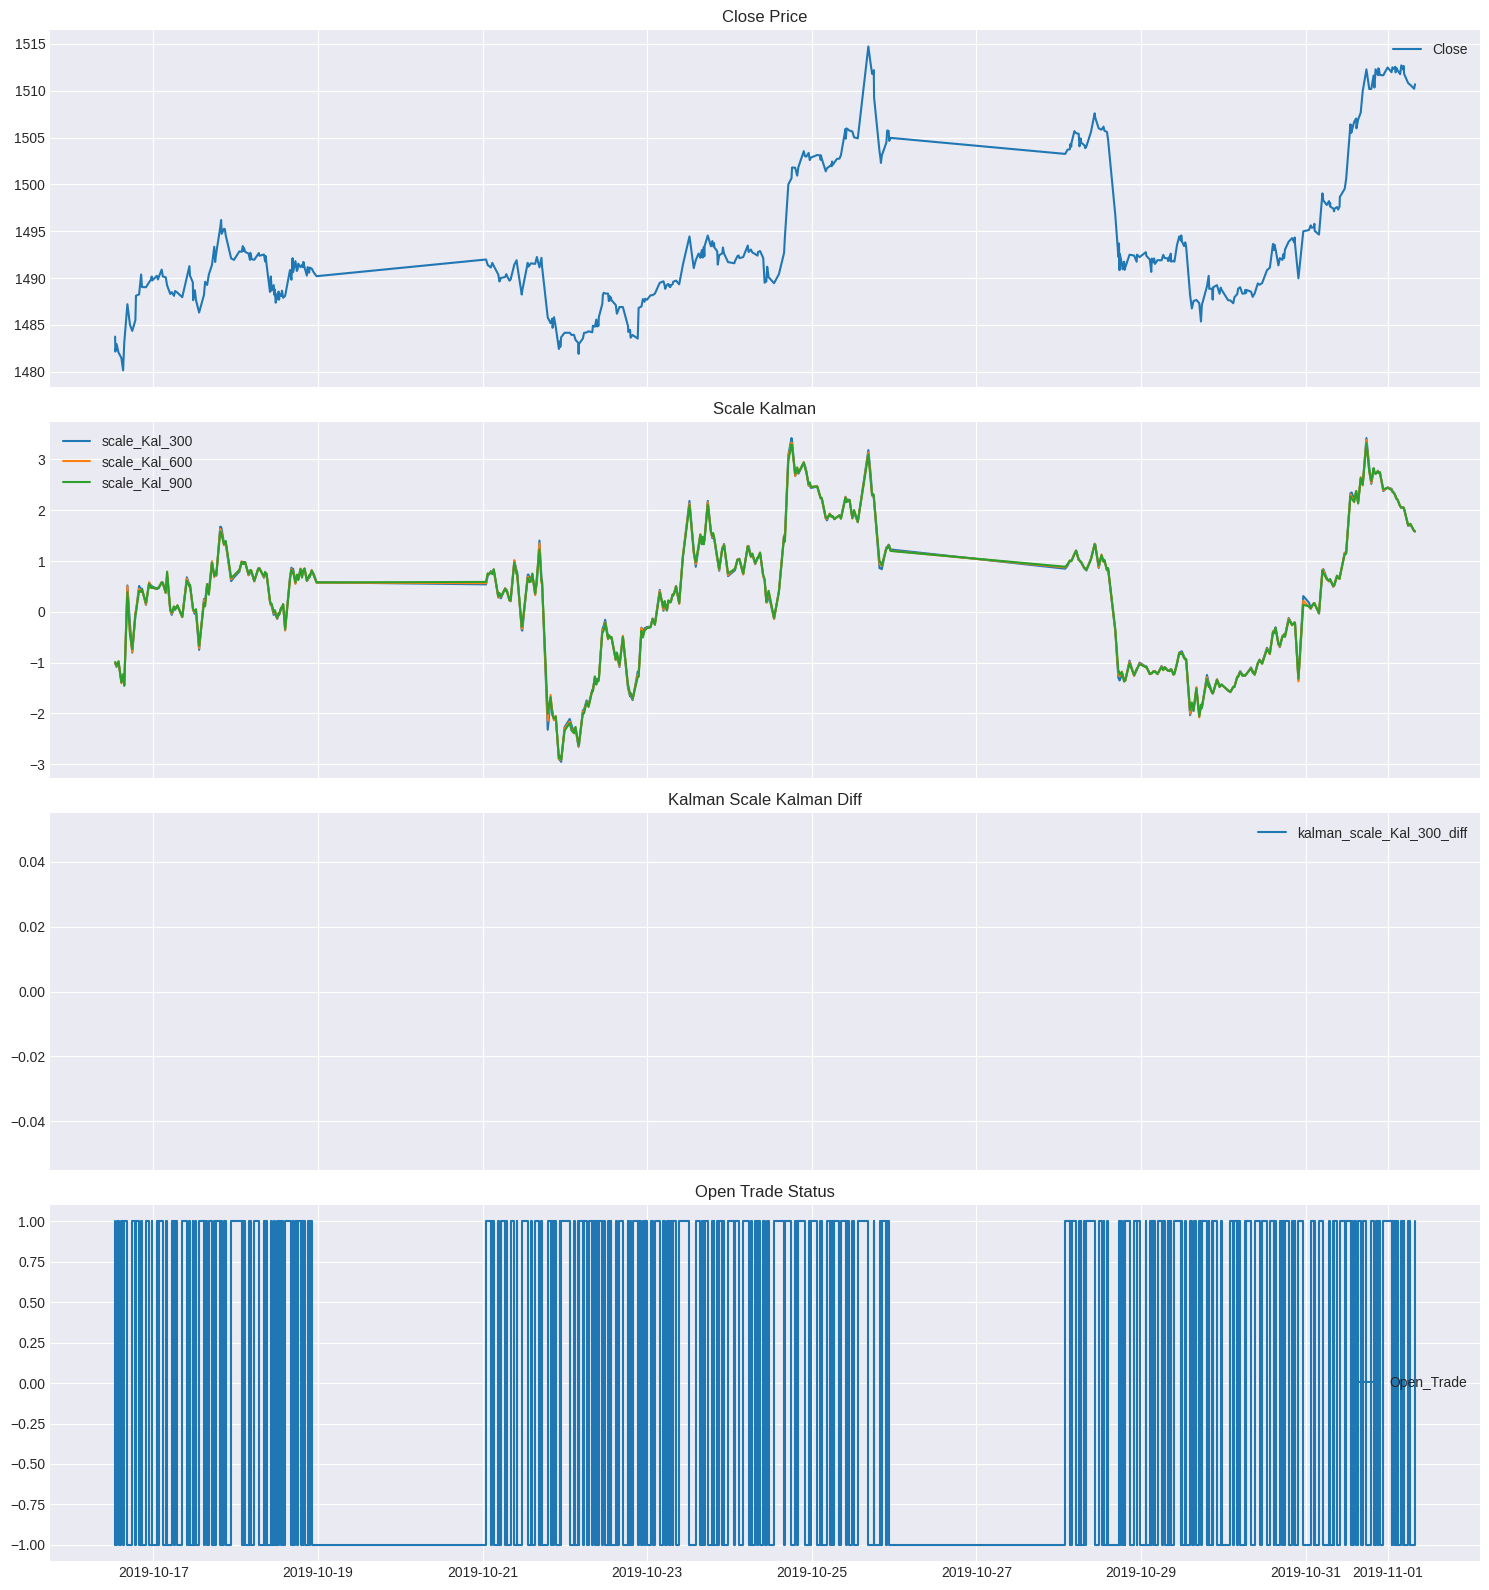

In [ ]:
# Define the row range for plotting (adjust as needed)
start_row = 8000
end_row = 8500

# Select the data for the specified row range from df
plot_df = df.iloc[start_row:end_row].copy()

# Ensure 'Date' column is datetime type and set as index for plotting
plot_df['Date'] = pd.to_datetime(plot_df['Date'])
plot_df = plot_df.set_index('Date')


# Define the columns to plot in each chart
chart1_cols = ['Close']
chart2_cols = ['scale_Kal_300', 'scale_Kal_600', 'scale_Kal_900']
chart3_cols = ['kalman_scale_Kal_300_diff']
chart4_cols = ['Open_Trade'] # Assuming 'Type' is represented by 'Open_Trade' in df based on previous cells

# Determine the number of subplots (only include charts with available columns in plot_df)
num_plots = 0
if any(col in plot_df.columns for col in chart1_cols): num_plots += 1
if any(col in plot_df.columns for col in chart2_cols): num_plots += 1
if any(col in plot_df.columns for col in chart3_cols): num_plots += 1
if any(col in plot_df.columns for col in chart4_cols): num_plots += 1


# Create the subplots
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(15, 4 * num_plots), sharex=True)

# Ensure axes is an array even if only one plot
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

current_plot_index = 0

# Plot Chart 1: Close Price
if any(col in plot_df.columns for col in chart1_cols):
    axes[current_plot_index].plot(plot_df.index, plot_df[chart1_cols])
    axes[current_plot_index].set_title('Close Price')
    axes[current_plot_index].grid(True)
    axes[current_plot_index].legend(chart1_cols)
    current_plot_index += 1


# Plot Chart 2: Scale Kalman indicators
if any(col in plot_df.columns for col in chart2_cols):
    axes[current_plot_index].plot(plot_df.index, plot_df[chart2_cols])
    axes[current_plot_index].set_title('Scale Kalman')
    axes[current_plot_index].grid(True)
    axes[current_plot_index].legend(chart2_cols)
    current_plot_index += 1

# Plot Chart 3: Kalman Scale Kalman Diff indicator
if any(col in plot_df.columns for col in chart3_cols):
    axes[current_plot_index].plot(plot_df.index, plot_df[chart3_cols])
    axes[current_plot_index].set_title('Kalman Scale Kalman Diff')
    axes[current_plot_index].grid(True)
    axes[current_plot_index].legend(chart3_cols)
    current_plot_index += 1

# Plot Chart 4: Trade Type (Open_Trade)
if any(col in plot_df.columns for col in chart4_cols):
    # For 'Open_Trade' which can be 1, -1, or 0, plotting directly might not be ideal.
    # We can scatter plot the entry points or plot a line representing the trade state.
    # Here, we'll plot the 'Open_Trade' values directly to show when trades are open.
    axes[current_plot_index].plot(plot_df.index, plot_df[chart4_cols], drawstyle='steps-post')
    axes[current_plot_index].set_title('Open Trade Status')
    axes[current_plot_index].grid(True)
    axes[current_plot_index].legend(chart4_cols)
    current_plot_index += 1


plt.tight_layout()
plt.show()

## ML

In [ ]:
# ===================== 1. ENTRENAR Y OBTENER IMPORTANCIAS =====================
def compute_xgb_importance(
    X: pd.DataFrame,
    y: pd.Series,
    task: str = "classification",
    random_state: int = 42,
    **xgb_params: Any
) -> Tuple[pd.DataFrame, Any]:
    """
    Entrena un modelo XGBoost y devuelve:
      - imp_df: DataFrame con 'feature', 'importance' y 'cum_importance'.
      - model : modelo ya entrenado.

    Soporta:
      • Clasificación binaria o multiclase (detecta nº de clases).
      • Regresión (si task != 'classification').

    Parámetros
    ----------
    X : pd.DataFrame
        Matriz de características (sin la columna objetivo).
    y : pd.Series
        Etiquetas objetivo. Puede ser binaria (0/1) o multiclase (0..K-1).
    task : str, opcional
        "classification" (default) o "regression".
    random_state : int, opcional
        Semilla para reproducibilidad.
    **xgb_params : dict
        Parámetros adicionales para el estimador de XGBoost.

    Returns
    -------
    (imp_df, model)
        imp_df : DataFrame con importancias y su acumulado.
        model  : instancia entrenada de XGBClassifier / XGBRegressor.
    """
    default_params: Dict[str, Any] = dict(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1,
        tree_method="hist",
    )
    default_params.update(xgb_params)

    if task == "classification":
        # Detectar nº de clases
        classes = np.unique(y)
        n_classes = len(classes)

        # XGBClassifier ajusta objetivo automáticamente, pero lo explicitamos:
        if n_classes > 2:
            default_params.setdefault("objective", "multi:softprob")
            default_params.setdefault("num_class", n_classes)
            eval_metric = "mlogloss"
        else:
            default_params.setdefault("objective", "binary:logistic")
            eval_metric = "logloss"

        model = XGBClassifier(eval_metric=eval_metric, **default_params)

    else:
        model = XGBRegressor(**default_params)

    model.fit(X, y)

    imp_df = (
        pd.DataFrame({
            "feature": X.columns,
            "importance": model.feature_importances_
        })
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )
    total_imp = imp_df["importance"].sum()
    if total_imp == 0:
        # Evitar división por cero si el modelo devuelve todo cero (raro, pero posible)
        imp_df["cum_importance"] = 0.0
    else:
        imp_df["cum_importance"] = imp_df["importance"].cumsum() / total_imp

    return imp_df, model

In [ ]:
# ===================== 2. SELECCIÓN DE FEATURES =====================
def select_features_with_importance(
    X: pd.DataFrame,
    imp_df: pd.DataFrame,
    top_n: Optional[int] = None,
    threshold: Optional[str | float] = None,
    cum_threshold: Optional[float] = 0.8
) -> Tuple[pd.DataFrame, List[str]]:
    """
    Selección flexible de variables a partir de importancias de XGBoost.

    Reglas:
      - Si top_n no es None           => usa el top_n.
      - Else si cum_threshold no None => usa importancia acumulada (p.ej. 0.8 = 80%).
      - Else usa threshold ('median', 'mean' o valor numérico).

    Devuelve (X_reducido, lista_de_features).

    Parámetros
    ----------
    X : pd.DataFrame
        Matriz de características original.
    imp_df : pd.DataFrame
        DataFrame devuelto por compute_xgb_importance.
    top_n : int | None
        Número fijo de variables a conservar.
    threshold : str | float | None
        Umbral de importancia. Si str, usar 'median' o 'mean'.
    cum_threshold : float | None
        Porcentaje acumulado de importancia (0-1). Si None, se ignora.

    Returns
    -------
    (X_sel, keep)
        X_sel : subset de X con columnas seleccionadas.
        keep  : lista de nombres de columnas seleccionadas.
    """
    if top_n is not None:
        keep = imp_df.head(top_n)["feature"].tolist()

    elif cum_threshold is not None:
        keep_mask = imp_df["cum_importance"] <= float(cum_threshold)
        keep = imp_df.loc[keep_mask, "feature"].tolist()
        # asegurar que haya al menos una más para no quedarnos exactamente en el corte
        if len(keep) < len(imp_df):
            keep.append(imp_df.iloc[len(keep)]["feature"])

    else:
        if threshold is None:
            threshold = "median"
        if isinstance(threshold, str):
            thr_val = imp_df["importance"].agg(threshold)
        else:
            thr_val = float(threshold)
        keep = imp_df.loc[imp_df["importance"] >= thr_val, "feature"].tolist()

    return X[keep], keep

In [ ]:
# ===================== 3. BÚSQUEDA DEL MEJOR UMBRAL ACUMULADO =====================
def find_best_cum_threshold(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_valid: pd.DataFrame,
    y_valid: pd.Series,
    task: str = "classification",
    thresholds: Tuple[float, ...] = (0.6, 0.7, 0.8, 0.9),
    random_state: int = 42,
    metric: str = "auto",
    **xgb_params: Any
) -> Tuple[float, pd.DataFrame, pd.DataFrame]:
    """
    Entrena un XGB en train, calcula importancias y prueba varios umbrales
    acumulados para ver cuál da la mejor métrica en valid.

    Para CLASIFICACIÓN:
        - Detecta nº de clases.
        - Métrica por defecto (metric="auto"):
            • Binaria: ROC-AUC (probabilidades de la clase positiva).
            • Multiclase: ROC-AUC macro OVR (usa predict_proba).
          Alternativas: metric="f1_macro", "accuracy", "logloss" (se MINIMIZA).
    Para REGRESIÓN:
        - Usa R^2.

    Devuelve:
        best_thr, res_df_ordenado_por_score_desc, imp_df

    Parámetros
    ----------
    X_train, y_train, X_valid, y_valid : pd.DataFrame / pd.Series
        Particiones de entrenamiento y validación.
    task : str
        "classification" (default) o "regression".
    thresholds : tuple[float, ...]
        Valores de umbral de importancia acumulada a evaluar (0-1).
    random_state : int
        Semilla para reproducibilidad.
    metric : str
        "auto" (default), "roc_auc", "f1_macro", "accuracy", "logloss" (clasif) o "r2" (regresión).
    **xgb_params : dict
        Parámetros extra para el estimador de XGBoost (pasan a compute y a los modelos internos).

    Returns
    -------
    (best_thr, res_df, imp_df)
        best_thr : float
            Umbral con mejor score (o menor logloss si metric='logloss').
        res_df : pd.DataFrame
            Tabla con resultados por umbral (n_features, score).
        imp_df : pd.DataFrame
            Importancias calculadas en X_train / y_train.
    """
    imp_df, _ = compute_xgb_importance(
        X_train, y_train, task=task, random_state=random_state, **xgb_params
    )

    results = []

    # Detectar nº de clases si es clasificación
    if task == "classification":
        classes = np.unique(y_train)
        n_classes = len(classes)
        if metric == "auto":
            metric_to_use = "roc_auc" if n_classes == 2 else "roc_auc"
        else:
            metric_to_use = metric
    else:
        metric_to_use = "r2" if metric == "auto" else metric

    for thr in thresholds:
        X_tr_sel, cols = select_features_with_importance(
            X_train, imp_df, cum_threshold=thr, top_n=None, threshold=None
        )
        X_va_sel = X_valid[cols]

        if task == "classification":
            params = dict(random_state=random_state, n_jobs=-1, tree_method="hist")
            params.update(xgb_params)

            if n_classes > 2:
                params.setdefault("objective", "multi:softprob")
                params.setdefault("num_class", n_classes)
                eval_metric = "mlogloss"
            else:
                params.setdefault("objective", "binary:logistic")
                eval_metric = "logloss"

            model_sel = XGBClassifier(eval_metric=eval_metric, **params)
            model_sel.fit(X_tr_sel, y_train)

            # Probabilidades y predicciones
            proba = model_sel.predict_proba(X_va_sel)
            pred  = np.argmax(proba, axis=1) if n_classes > 2 else (proba[:, 1] >= 0.5).astype(int)

            # Calcular métrica
            if metric_to_use == "roc_auc":
                if n_classes == 2:
                    score = roc_auc_score(y_valid, proba[:, 1])
                else:
                    # AUC macro One-vs-Rest
                    score = roc_auc_score(y_valid, proba, multi_class="ovr", average="macro")
            elif metric_to_use == "f1_macro":
                score = f1_score(y_valid, pred, average="macro")
            elif metric_to_use == "accuracy":
                score = accuracy_score(y_valid, pred)
            elif metric_to_use == "logloss":
                # En este caso, menor es mejor. Guardamos negativo para mantener criterio "mayor mejor".
                score = -log_loss(y_valid, proba, labels=np.unique(y_train))
            else:
                raise ValueError(f"Métrica no soportada: {metric_to_use}")

        else:
            # REGRESIÓN
            params = dict(random_state=random_state, n_jobs=-1, tree_method="hist")
            params.update(xgb_params)
            model_sel = XGBRegressor(**params)
            model_sel.fit(X_tr_sel, y_train)
            pred = model_sel.predict(X_va_sel)

            if metric_to_use == "r2":
                score = r2_score(y_valid, pred)
            else:
                raise ValueError(f"Métrica de regresión no soportada: {metric_to_use}")

        results.append({"cum_threshold": thr, "n_features": len(cols), "score": score})

    # Ordenar (si usamos logloss negado, mayor sigue siendo mejor)
    res_df = pd.DataFrame(results).sort_values("score", ascending=False).reset_index(drop=True)
    best_thr = float(res_df.iloc[0]["cum_threshold"])
    return best_thr, res_df, imp_df

In [ ]:
def remove_highly_correlated_features(df, threshold=0.9):

    # Solo numéricos para evitar errores y acelerar
    corr_matrix = df.corr(numeric_only=True).abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1))

    to_drop = []
    for col in tqdm(upper.columns, desc=f"Pruning corr > {threshold}", unit="col", leave=False):
        if (upper[col] > threshold).any():
            to_drop.append(col)

    return df.drop(columns=to_drop, errors="ignore"), to_drop


In [ ]:
# ===================== 3. PIPELINE PRINCIPAL =====================
df = df.dropna()
y = df['label']
X = df.iloc[:, 2:]

# --- 3.3 Split temporal (ejemplo simple 80/20) ---
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# --- 3.4 Remove correlated features ---
X_train_filtered, dropped_features = remove_highly_correlated_features(X_train, threshold=0.9)
X_test_filtered = X_test.drop(columns=dropped_features)

# Baseline logistic regression with time-series CV
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_filtered)
tscv = TimeSeriesSplit(n_splits=5)
baseline = cross_val_score(LogisticRegression(max_iter=1000), X_scaled, y_train, cv=tscv).mean()
print('Logistic regression CV accuracy:', baseline)

# --- 3.5 Importancias con XGBoost ---
imp_df, xgb_model = compute_xgb_importance(X_train_filtered, y_train, task='classification')

print('=== Importancias XGBoost ===')
print(imp_df.head(20))
print(f'Total features: {len(imp_df)}')

# --- 3.6 Selección (elige una opción) ---
X_train_sel, keep_cols = select_features_with_importance(X_train_filtered, imp_df, cum_threshold=0.8)
X_test_sel = X_test_filtered[keep_cols]

print(f'Features seleccionadas: {len(keep_cols)}')
importance_map = imp_df.set_index("feature")["importance"]
selected_importances = pd.DataFrame({
    "feature": keep_cols,
    "importance": importance_map.reindex(keep_cols).values
})
selected_importances.to_csv(results_dir / f"{symbol}_{direction}_M5M10_{data_type}_ImportantCols.csv", index=False)

# Save dataset with selected features
df_selected = df[['Date', 'label'] + keep_cols]
df_selected.to_csv(results_dir / f"{symbol}_{direction}_M5M10_{data_type}_Features.csv", index=False)

# Time-series cross-validation with XGBoost
xgb_cv = XGBClassifier(eval_metric='logloss', n_estimators=500, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, tree_method='hist')
xgb_scores = cross_val_score(xgb_cv, X_train_sel, y_train, cv=tscv, scoring='accuracy')
print('XGBoost CV accuracy:', xgb_scores.mean())
